<figure>
  <img style="float: left;" src="./figures/unine.png" width="200"/>
</figure>

<figure>
  <img style="float: left;" src="./figures/fair_1.png" width="200"/>
</figure>

# Fairness

Machine learning (ML) usage is increasing every day. Companies and organisations build ML models with the purpose of minimising human effort or improving performance in various tasks. So today Machine learning arguably affects our lives.

Examples:
1. Recommendation system
2. Face recognition
3. Self-driving cars
4. Candidate selection e.x college admissions, CV screening
5. Loan admissions

There are a lot of examples that researchers demonstrate inadvertently discriminating against several population groups.    
The most know is [ProPublica's](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) research in COMPAS Dataset.

When machine learning models are being used to make decisions, they cannot be separated from the social and ethical context in which they are applied, and those developing and deploying these models must take care to do so in a manner that accounts for both performance and fairness. 

So in the last decade Fairness has become one of the most active research areas in ML.

# Sources of Bias.

Bias may be introduced into a machine learning project at any step along the way, and it is important to carefully think through each potential source and how it may affect your results.


Source of bias:
- Data
    1. Historical injustice.
    2. Sample bias - Collection Bias.
    3. Limited features.
    4. Unbalanced dataset.
    5. Proxy Variables.
- Modelling
    1. Data preprocessing
    2. Model assumptions 
- Feedback loops.
    1. decisions based on biassed models lead to biassed dataset.  

<figure>
  <img style="float: left;" src="./figures/simple_pipeline.png" width="600"/>
</figure>


# Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils import compute_metric
from utils import predict_with_threshold

In [3]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"


In [4]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [5]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [6]:
features = train_data.columns.difference([target_column])

# we define sex as our sensitive feature
sensitive_feature = ["sex"]

# all the rest are non sensitive feature
non_sensitive_features = list(set(features).difference(set(sensitive_feature)))

In [7]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,6,9,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,9,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,11,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,1,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,9,13,2,9,5,2,0,0.0,0,40,4,0


### Load Pevius results

In [8]:
# load privius results
all_results = pd.read_csv("./results_v1.csv")
all_results = all_results.set_index("metrics")

<AxesSubplot: xlabel='metrics'>

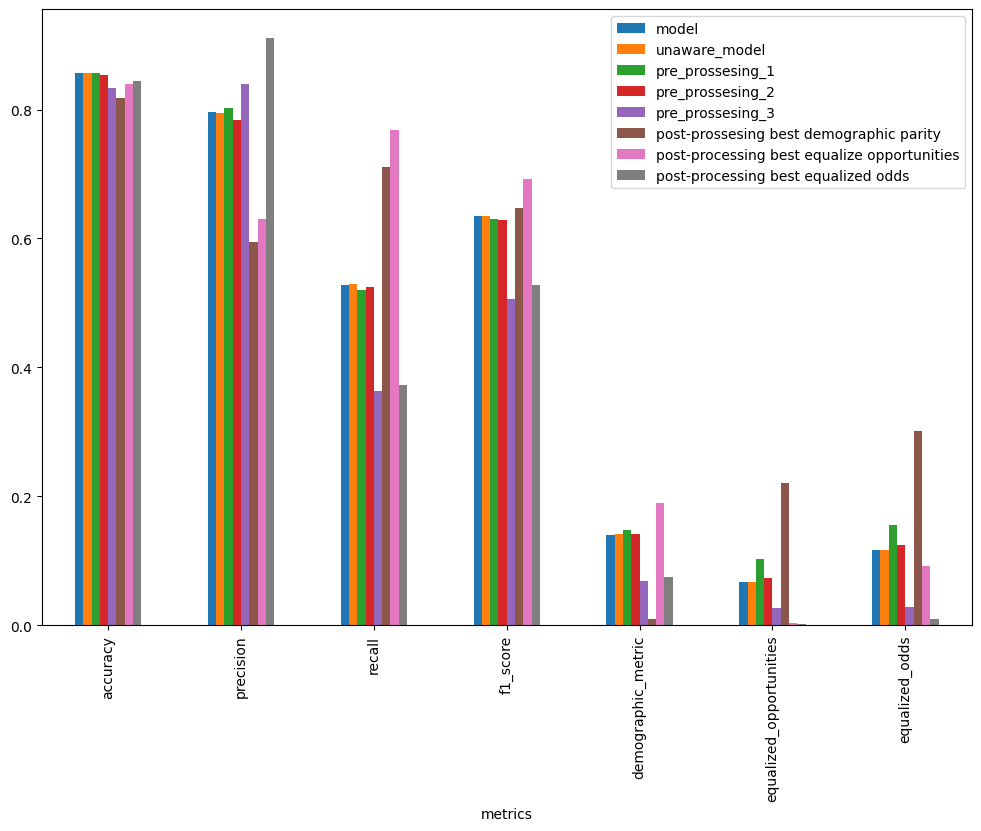

In [9]:
all_results.plot(kind="bar",figsize=(12,8))

# In-prossesing Method

In-prossesing tenchiques apply **constrains or reguralization terms** when we optimized a model.

In this section we will create a **Deep Neural Network** and aply **reguralization** technique in order to create a fair model using **tensorflow** library. Reguralization term are very convienient when we perform Gradient Desent methods.

In this example we will try to fix **demographic parity** but we can apply the same methods we can reduce any critiria we wish.

# Define and train vanila DNN using tensorflow

In [10]:
import tensorflow as tf

In [11]:
input_layer = tf.keras.Input(shape=(13,))
x = tf.keras.layers.Dense(64, activation='relu')(input_layer)
propa = tf.keras.layers.Dense(1, activation='sigmoid')(x)
nn_model = tf.keras.Model(inputs = input_layer, outputs = propa)

In [12]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
batch_size = 256
nn_model.compile(optimizer = optimizer,
                 loss = "binary_crossentropy",
                 metrics = "accuracy")

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                      patience = 100)

history = nn_model.fit(train_data[non_sensitive_features + sensitive_feature],
                       train_data[[target_column]],
                       validation_split = 0.2,
                       batch_size=batch_size,
                       epochs=1000,
                       callbacks=es,
                       shuffle=True).history

Epoch 1/1000


2022-12-06 04:12:55.115882: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


91/91 [==============================] - 0s 1ms/step - loss: 2.3873 - accuracy: 0.7408 - val_loss: 0.5246 - val_accuracy: 0.7808
Epoch 2/1000
91/91 [==============================] - 0s 638us/step - loss: 0.5078 - accuracy: 0.7995 - val_loss: 0.4703 - val_accuracy: 0.7992
Epoch 3/1000
91/91 [==============================] - 0s 571us/step - loss: 0.5054 - accuracy: 0.8066 - val_loss: 0.4522 - val_accuracy: 0.8036
Epoch 4/1000
91/91 [==============================] - 0s 578us/step - loss: 0.5232 - accuracy: 0.8069 - val_loss: 0.4960 - val_accuracy: 0.7992
Epoch 5/1000
91/91 [==============================] - 0s 580us/step - loss: 0.5762 - accuracy: 0.8059 - val_loss: 0.5656 - val_accuracy: 0.8049
Epoch 6/1000
91/91 [==============================] - 0s 597us/step - loss: 0.5062 - accuracy: 0.8139 - val_loss: 0.4346 - val_accuracy: 0.8124
Epoch 7/1000
91/91 [==============================] - 0s 548us/step - loss: 0.5007 - accuracy: 0.8118 - val_loss: 0.4396 - val_accuracy: 0.8065
Epoch 8

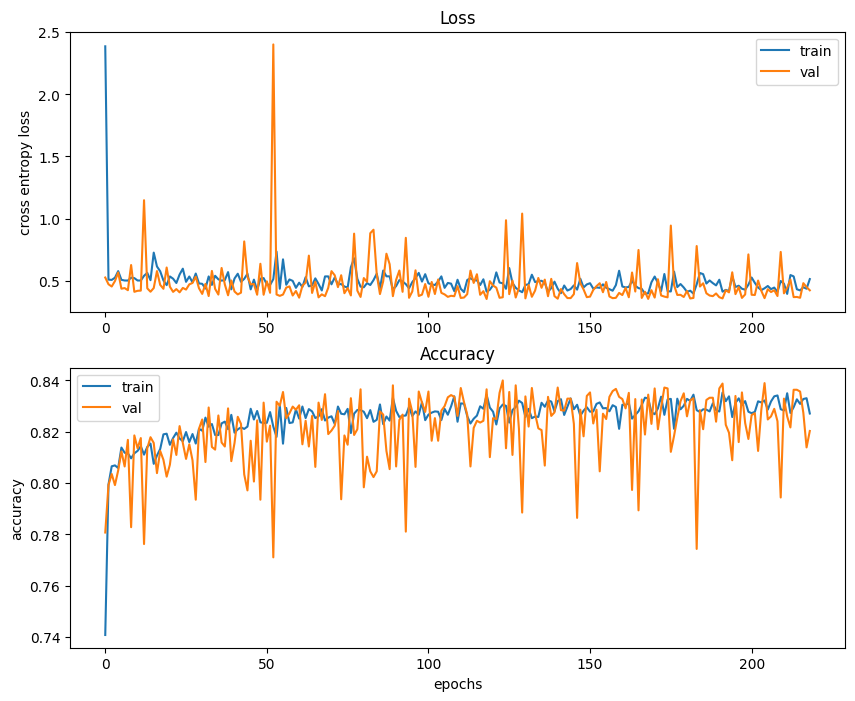

In [14]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(10,8))
ax[0].plot(history["loss"], label="train")
ax[0].plot(history["val_loss"], label="val")
ax[0].set_ylabel("cross entropy loss")
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(history["accuracy"], label="train")
ax[1].plot(history["val_accuracy"], label="val")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].set_title("Accuracy")
plt.xlabel("epochs")
plt.show()
plt.close()

In [15]:
predicted_probabilities_nn = nn_model.predict(test_data[non_sensitive_features + sensitive_feature])

475/475 [==============================] - 0s 249us/step


In [16]:
predictions_nn = predict_with_threshold(probabilities = predicted_probabilities_nn,
                                        threshold = 0.5)
    
metrics_nn = compute_metric(y_pred = predictions_nn,
                            y_true = test_data[target_column],
                            sensitive_feature = test_data[sensitive_feature[0]])

metrics_nn = pd.DataFrame(metrics_nn,index=["Neural Network"])

In [17]:
all_results = pd.concat([all_results, metrics_nn.T],axis=1)

<AxesSubplot: >

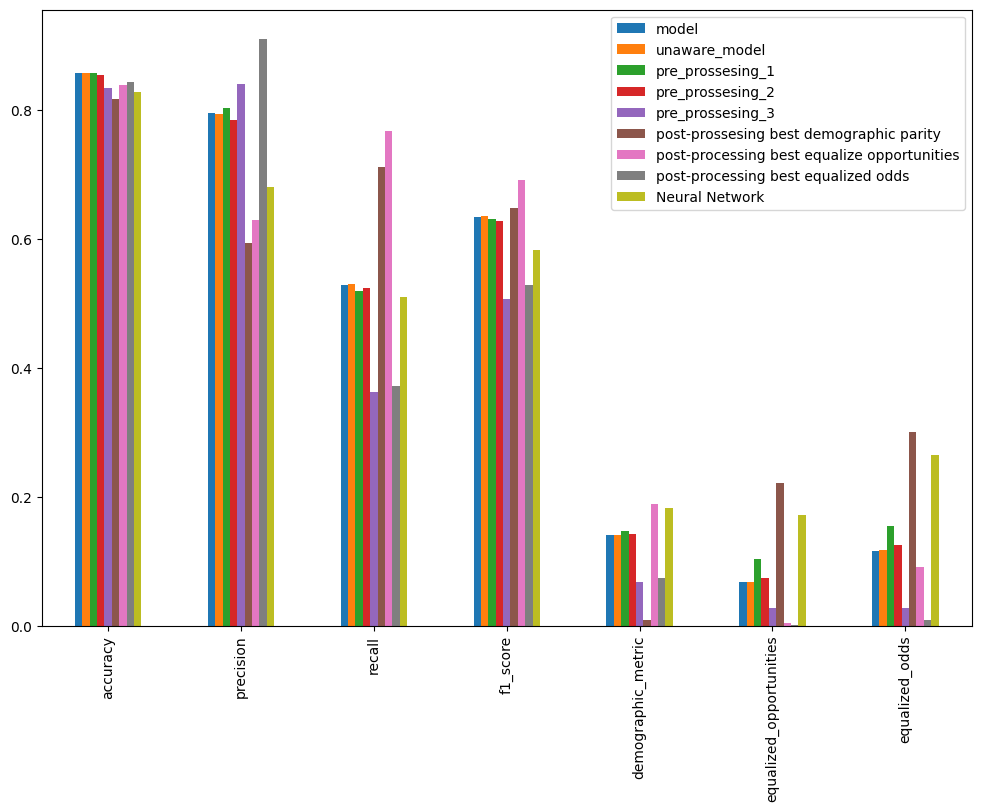

In [18]:
all_results.plot(kind="bar",figsize=(12,8))

# Reguralization Method

In-Processing techiques considers fairness in the optimizion prossec of a classifier.

A typical strategy is to guide the model with fairness regularization so that predictions are less dependent on the sensitive attributes.

A general objectivefunction with fairness learning is formulated as:

<figure>
  <img style="float: center;" src="./figures/loss.png" width="200"/>
</figure>

Depending on the fairness critiria we use differnent reguralization terms.

1. Demographic parity: $$ P_c(\hat{Y}= 1 | S = 0 ) =  P_c(\hat{Y}= 1 | S = 1 ) $$
2. Equalized oportunities: $$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$
3. Equalized odds: $$ P_c(\hat{Y}= 1 | S = 0, Y = y ) =  P_c(\hat{Y}= 1 | S = 0, Y = y ) \forall y\in {0,1} $$

In practice reguralization term compare the distributions of the outcome propabilities for each group over a batch.

Bellowe we can ilustrate the prossecc having using 2 different sub batches for each group respectivly.

<figure>
  <img style="float: left;" src="./figures/reg.png" width="1000"/>
</figure>

The easiest way to compare 2 propability distribution in to compare their main values.

<figure>
  <img style="float: center;" src="./figures/c_dist.png" width="400"/>
</figure>

# Create batch balanced dataset

In order to have acturate propabilities on each batch we have to use a big batch size.

In [19]:
mask_group_0 = train_data[sensitive_feature[0]] == 0
mask_group_1 = np.logical_not(mask_group_0)

In [20]:
x_train_g1 = train_data[non_sensitive_features+sensitive_feature].loc[mask_group_0]
x_train_g2 = train_data[non_sensitive_features+sensitive_feature].loc[mask_group_1]

y_train_g1 = train_data[[target_column]].loc[mask_group_0]*1.0
y_train_g2 = train_data[[target_column]].loc[mask_group_1]*1.0

In [21]:
x_tf_dataset_g1 = tf.data.Dataset.from_tensor_slices(x_train_g1)
y_tf_dataset_g1 = tf.data.Dataset.from_tensor_slices(y_train_g1)
tf_dataset_g1 = tf.data.Dataset.zip((x_tf_dataset_g1, y_tf_dataset_g1))
tf_dataset_g1 = tf_dataset_g1.shuffle(buffer_size=1000).batch(batch_size=1000//2, drop_remainder=True).repeat()

x_tf_dataset_g2 = tf.data.Dataset.from_tensor_slices(x_train_g2)
y_tf_dataset_g2 = tf.data.Dataset.from_tensor_slices(y_train_g2)
tf_dataset_g2 = tf.data.Dataset.zip((x_tf_dataset_g2,y_tf_dataset_g2))
tf_dataset_g2 = tf_dataset_g2.shuffle(buffer_size=1000).batch(batch_size=1000//2,drop_remainder=True).repeat()

final_tf_dataset = tf.data.Dataset.zip((tf_dataset_g1,tf_dataset_g2))

# Demographic parity


Demographic parity
$$ P_c(\hat{Y}= 1 |,S = 0 ) =  P_c(\hat{Y}= 1 | S = 1 ) $$

Our reguralization term can be defined on each batch as following:
$$ R = d (p(\hat{y} = 1  | S = 0 ), p(\hat{y} | S = 1 ) )$$

$$ = \dfrac{\sum_{i=1}^{\text{batch size group 0}} p(\hat{y} |x_i )}{\text{batch size group 0}}  - \dfrac{\sum_{j=1}^{\text{batch size group 1}} p(\hat{y} |x_j )}{\text{batch size group 1}} $$

$$ = \dfrac{\sum_{i=1}^{\text{batch size group 0}} model(xi)}{\text{batch size group 0}}  - \dfrac{\sum_{j=1}^{\text{batch size group 1}} model(xj)}{\text{batch size group 1}} $$

In [22]:
class DemographicParityTrainer(tf.keras.Model):
    
    def __init__(self, l, **kwargs):
        super(DemographicParityTrainer, self).__init__(**kwargs)
        self.l = l
        
    @tf.function
    def train_step(self, data):
        # unwrap dataset
        (x_g1, y_g1), (x_g2, y_g2) = data
        
        with tf.GradientTape() as tape:
            p_y_g1 = self(x_g1)
            p_y_g2 = self(x_g2)
            
            # main loss
            loss_bce_g0 = self.compiled_loss(y_g1, p_y_g1)
            loss_bce_g1 = self.compiled_loss(y_g2, p_y_g2)
            loss_bce = (loss_bce_g0 + loss_bce_g1) / 2
            
            # reguralization loss
            mean_p_g1 = tf.reduce_mean(p_y_g1)
            mean_p_g2 = tf.reduce_mean(p_y_g2)
            fairness_loss = tf.math.square(mean_p_g1 - mean_p_g2)
            
            total_loss = loss_bce + self.l * fairness_loss 
            
        trainable_variable = self.trainable_variables
        grads = tape.gradient(total_loss, trainable_variable)
        self.optimizer.apply_gradients(zip(grads, trainable_variable))
        self.compiled_metrics.update_state(tf.concat([y_g1,y_g2],axis=0),
                                           tf.concat([p_y_g1,p_y_g2],axis=0))
        metrics_display = {m.name : m.result() for m in self.metrics}
        metrics_display["fairness_loss"] = fairness_loss 
        return metrics_display

In [23]:
lr = 0.001
l = 2.0

In [24]:
# get model
input_layer = tf.keras.Input(shape=(13,))
x = tf.keras.layers.Dense(64, activation='relu')(input_layer)
propa = tf.keras.layers.Dense(1, activation='sigmoid')(x)
demographic_parity_model = DemographicParityTrainer(inputs = input_layer, outputs = propa, l=l)

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
demographic_parity_model.compile(optimizer = optimizer,
                                 loss = "binary_crossentropy",
                                 metrics = "accuracy")

In [26]:
history = demographic_parity_model.fit(final_tf_dataset,
                                       steps_per_epoch= 1000,
                                       epochs=10,
                                       shuffle=True,
                                       verbose=1).history

Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 2.3446 - accuracy: 0.8129 - fairness_loss: 0.0045
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4084 - accuracy: 0.8356 - fairness_loss: 0.0056
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4104 - accuracy: 0.8413 - fairness_loss: 0.0060
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3777 - accuracy: 0.8430 - fairness_loss: 0.0060
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3942 - accuracy: 0.8429 - fairness_loss: 0.0061
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3890 - accuracy: 0.8431 - fairness_loss: 0.0061
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3766 - accuracy: 0.8448 - fairness_loss: 0.0061
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3915 - accuracy: 0.8439 - fairness_loss:

In [27]:
# get metrics
predicted_probabilities = demographic_parity_model.predict(test_data[non_sensitive_features + sensitive_feature])

predictions_nn = predict_with_threshold(probabilities = predicted_probabilities,
                                        threshold = 0.5)

demographic_parity_metrics = compute_metric(y_pred = predictions_nn,
                                            y_true = test_data[target_column],
                                            sensitive_feature = test_data[sensitive_feature[0]])

demographic_parity_metrics = pd.DataFrame(demographic_parity_metrics, index=["nn demographic parity "])

475/475 [==============================] - 0s 227us/step


<AxesSubplot: >

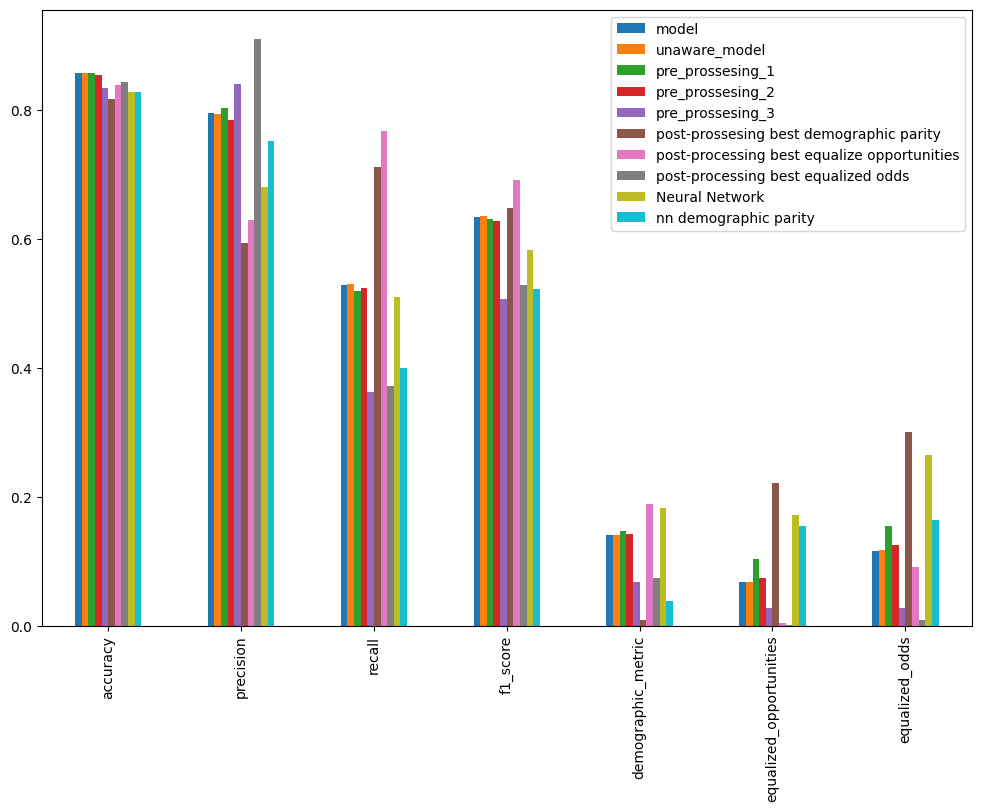

In [28]:
all_results = pd.concat([all_results, demographic_parity_metrics.T],axis=1)
all_results.plot(kind="bar",figsize=(12,8))

# Equalized oportunities


Equalized oportunities
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$

Our reguralization term can be defined on each batch as following:
$$ R = d (p(\hat{y} = 1  | S = 0, Y = 1 ), p(\hat{y} | S = 1, Y = 1 ) )$$

$$ = E_{g1}[p(\hat{y} |x_i, y_i=1 )] - E_{g2}[p(\hat{y} |x_i, y_i=1 )] $$

$$ = \dfrac{\sum_{i=1}^{\text{batch size group 0}} model(xi)* y_i}{\sum_{i=1}^{\text{batch size group 0}} y_i }  -            \dfrac{\sum_{i=1}^{\text{batch size group 1}} model(xi)* y_j}{\sum_{i=1}^{\text{batch size group 1}} y_j } $$

In [29]:
tf.keras.backend.set_floatx('float64')

class EqualizeOpportunitiesTrainer(tf.keras.Model):
    
    def __init__(self, l, **kwargs):
        super(EqualizeOpportunitiesTrainer, self).__init__(**kwargs)
        self.l = l
        
    @tf.function
    def train_step(self, data):
        # unwrap dataset
        (x_g1, y_g1), (x_g2, y_g2) = data
        
        with tf.GradientTape() as tape:
            p_y_g1 = self(x_g1)
            p_y_g2 = self(x_g2)
            
            # main loss
            loss_bce_g0 = self.compiled_loss(y_g1, p_y_g1)
            loss_bce_g1 = self.compiled_loss(y_g2, p_y_g2)
            loss_bce = (loss_bce_g0 + loss_bce_g1) / 2
            
            # reguralization loss 1
            reshape_p_g1 = tf.reshape(p_y_g1,[-1])
            reshape_y_g1 = tf.reshape(y_g1,[-1])
            reshape_p_g2 = tf.reshape(p_y_g2,[-1])
            reshape_y_g2 = tf.reshape(y_g2,[-1])
            
            mean_tpr1 = tf.reduce_sum(reshape_p_g1 * reshape_y_g1)/tf.reduce_sum(reshape_y_g1)
            mean_tpr2 = tf.reduce_sum(reshape_p_g2 * reshape_y_g2)/tf.reduce_sum(reshape_y_g2)
            true_positive_distance = tf.math.square(mean_tpr1 - mean_tpr2)
            
            total_loss = loss_bce + self.l * true_positive_distance 
            
        trainable_variable = self.trainable_variables
        grads = tape.gradient(total_loss, trainable_variable)
        self.optimizer.apply_gradients(zip(grads, trainable_variable))
        self.compiled_metrics.update_state(tf.concat([y_g1,y_g2],axis=0),
                                           tf.concat([p_y_g1,p_y_g2],axis=0))
        metrics_display = {m.name : m.result() for m in self.metrics}
        metrics_display["fairness_loss"] = true_positive_distance 
        return metrics_display

In [30]:
lr = 0.001
l =  3.0

In [31]:
# get model
input_layer = tf.keras.Input(shape=(13,))
x = tf.keras.layers.Dense(64, activation='relu')(input_layer)
propa = tf.keras.layers.Dense(1, activation='sigmoid')(x)
equalize_opportunities_model = EqualizeOpportunitiesTrainer(inputs = input_layer, outputs = propa, l=l)

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
equalize_opportunities_model.compile(optimizer = optimizer,
                                     loss = "binary_crossentropy",
                                     metrics = "accuracy")

In [33]:
history = equalize_opportunities_model.fit(final_tf_dataset,
                                           steps_per_epoch= 1000,
                                           epochs=10,
                                           shuffle=True).history

Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7843 - accuracy: 0.8151 - fairness_loss: 0.0031
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4113 - accuracy: 0.8380 - fairness_loss: 0.0027
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4155 - accuracy: 0.8438 - fairness_loss: 0.0027
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3941 - accuracy: 0.8459 - fairness_loss: 0.0026
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3907 - accuracy: 0.8456 - fairness_loss: 0.0026
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3930 - accuracy: 0.8461 - fairness_loss: 0.0027
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4035 - accuracy: 0.8451 - fairness_loss: 0.0026
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3941 - accuracy: 0.8471 - fairness_loss:

In [34]:
# get metrics
predicted_probabilities = equalize_opportunities_model.predict(test_data[non_sensitive_features + sensitive_feature])

predictions_nn = predict_with_threshold(probabilities = predicted_probabilities,
                                        threshold = 0.5)
equalize_opportunities_metrics = compute_metric(y_pred = predictions_nn,
                                                y_true = test_data[target_column],
                                                sensitive_feature = test_data[sensitive_feature[0]])

equalize_opportunities_metrics = pd.DataFrame(equalize_opportunities_metrics, index=["nn equalize opportunities "])

475/475 [==============================] - 0s 228us/step


<AxesSubplot: >

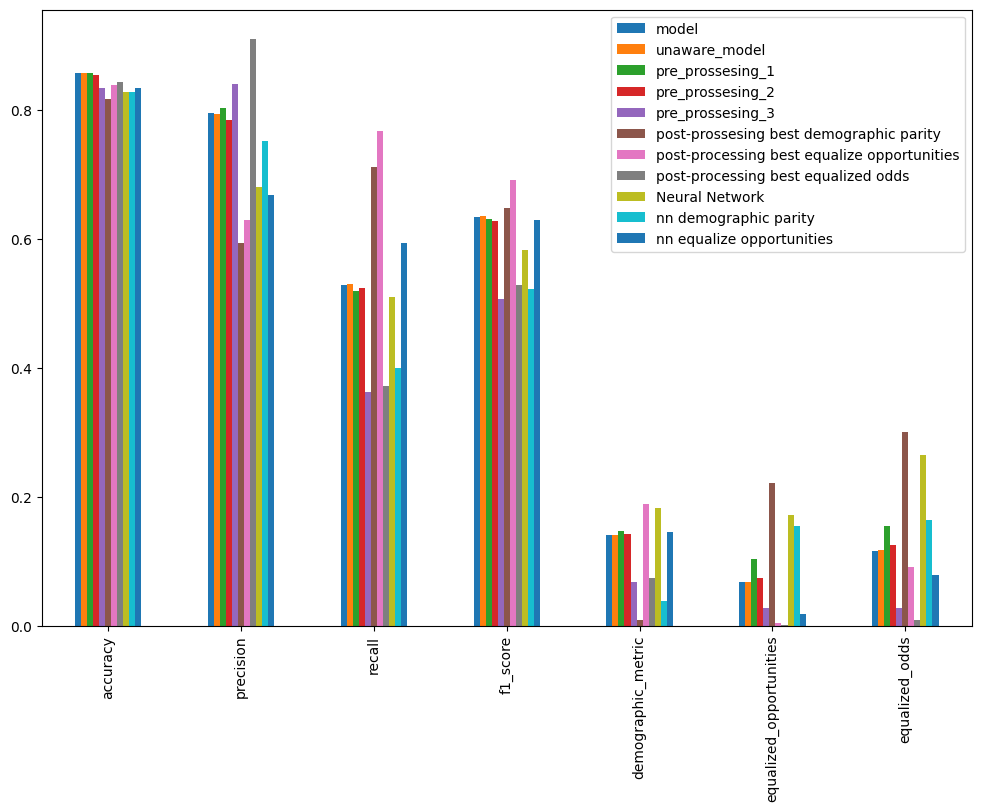

In [35]:
all_results = pd.concat([all_results, equalize_opportunities_metrics.T],axis=1)
all_results.plot(kind="bar",figsize=(12,8))

# Equalized odds

Equalized odds
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$
$$ \&$$
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$

Our reguralization term can be defined on each batch as following:
$$ R = d1 + d2$$

Where : 

$$ d1 =  E_{g1}[p(\hat{y} |x_i, y_i=1 )] - E_{g2}[p(\hat{y} |x_i, y_i=1 )] $$

$$ = \dfrac{\sum_{i=1}^{\text{batch size group 0}} model(xi)* y_i}{\sum_{i=1}^{\text{batch size group 0}} y_i }  -            \dfrac{\sum_{i=1}^{\text{batch size group 1}} model(xi)* y_j}{\sum_{i=1}^{\text{batch size group 1}} y_j } $$

$$ d2 =  E_{g1}[p(\hat{y} |x_i, y_i=0 )] - E_{g2}[p(\hat{y} |x_i, y_i=0 )] $$

$$ = \dfrac{\sum_{i=1}^{\text{batch size group 0}} model(xi)* (1-y_i)}{\sum_{i=1}^{\text{batch size group 0}} (1-y_i) }  -            \dfrac{\sum_{i=1}^{\text{batch size group 1}} model(xi)* (1-y_j)}{\sum_{i=1}^{\text{batch size group 1}} (1-y_j) } $$

In [36]:
class EqualizeOddsTrainer(tf.keras.Model):
    
    def __init__(self, l, **kwargs):
        super(EqualizeOddsTrainer, self).__init__(**kwargs)
        self.l = l
        
    @tf.function
    def train_step(self, data):
        # unwrap dataset
        (x_g1, y_g1), (x_g2, y_g2) = data
        
        with tf.GradientTape() as tape:
            p_y_g1 = self(x_g1)
            p_y_g2 = self(x_g2)
            
            # main loss
            loss_bce_g0 = self.compiled_loss(y_g1, p_y_g1)
            loss_bce_g1 = self.compiled_loss(y_g2, p_y_g2)
            loss_bce = (loss_bce_g0 + loss_bce_g1) / 2
            
            # reguralization loss 1
            reshape_p_g1 = tf.reshape(p_y_g1,[-1])
            reshape_y_g1 = tf.reshape(y_g1,[-1])
            reshape_p_g2 = tf.reshape(p_y_g2,[-1])
            reshape_y_g2 = tf.reshape(y_g2,[-1])
            
            mean_tpr1 = tf.reduce_sum(reshape_p_g1 * reshape_y_g1)/tf.reduce_sum(reshape_y_g1)
            mean_tpr2 = tf.reduce_sum(reshape_p_g2 * reshape_y_g2)/tf.reduce_sum(reshape_y_g2)
            true_positive_distance = tf.math.square(mean_tpr1 - mean_tpr2)
            
            # reguralization loss 2
            mean_fpr1 = tf.reduce_sum(reshape_p_g1 * (1-reshape_y_g1))/tf.reduce_sum((1-reshape_y_g1))
            mean_fpr2 = tf.reduce_sum(reshape_p_g2 * (1-reshape_y_g2))/tf.reduce_sum((1-reshape_y_g2))
            false_positive_distance = tf.math.square(mean_fpr1 - mean_fpr2)
            # sum of fairness metrics
            fairness_loss =  (true_positive_distance + false_positive_distance )/2
            # total loss
            total_loss = loss_bce + self.l * fairness_loss
            
        trainable_variable = self.trainable_variables
        grads = tape.gradient(total_loss, trainable_variable)
        self.optimizer.apply_gradients(zip(grads, trainable_variable))
        self.compiled_metrics.update_state(tf.concat([y_g1,y_g2],axis=0),
                                           tf.concat([p_y_g1,p_y_g2],axis=0))
        metrics_display = {m.name : m.result() for m in self.metrics}
        metrics_display["fairness_loss"] = fairness_loss
        metrics_display["fairness_tpr"] = true_positive_distance
        metrics_display["fairness_fpr"] = false_positive_distance
        return metrics_display

In [37]:
lr = 0.001
l = 3.0

In [38]:
# get model
input_layer = tf.keras.Input(shape=(13,))
x = tf.keras.layers.Dense(64, activation='relu')(input_layer)
propa = tf.keras.layers.Dense(1, activation='sigmoid')(x)
equalize_odds_model = EqualizeOddsTrainer(inputs = input_layer, outputs = propa, l=l)

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
equalize_odds_model.compile(optimizer = optimizer,
                            loss = "binary_crossentropy",
                            metrics = "accuracy")

In [40]:
history = equalize_odds_model.fit(final_tf_dataset,
                                  steps_per_epoch= 1000,
                                  epochs=10,
                                  shuffle=True).history

Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7930 - accuracy: 0.8201 - fairness_loss: 0.0022 - fairness_tpr: 0.0034 - fairness_fpr: 0.0011
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3926 - accuracy: 0.8388 - fairness_loss: 0.0026 - fairness_tpr: 0.0028 - fairness_fpr: 0.0025
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3849 - accuracy: 0.8446 - fairness_loss: 0.0031 - fairness_tpr: 0.0026 - fairness_fpr: 0.0036
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3783 - accuracy: 0.8465 - fairness_loss: 0.0033 - fairness_tpr: 0.0027 - fairness_fpr: 0.0039
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3646 - accuracy: 0.8482 - fairness_loss: 0.0032 - fairness_tpr: 0.0025 - fairness_fpr: 0.0039
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3743 - accuracy: 0.8478 - fairness_loss: 0.0034 - fairness_tpr

In [41]:
# get metrics
predicted_probabilities = equalize_odds_model.predict(test_data[non_sensitive_features + sensitive_feature])

predictions_nn = predict_with_threshold(probabilities = predicted_probabilities,
                                        threshold = 0.5)

equalize_odds_metrics = compute_metric(y_pred = predictions_nn,
                                  y_true = test_data[target_column],
                                  sensitive_feature = test_data[sensitive_feature[0]])
equalize_odds_metrics = pd.DataFrame(equalize_odds_metrics,index=[f"nn equalized odds"])

475/475 [==============================] - 0s 231us/step


In [42]:
equalize_odds_metrics

,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds
nn equalized odds,0.843427,0.748855,0.5035,0.602143,0.107172,0.021891,0.053554


<AxesSubplot: >

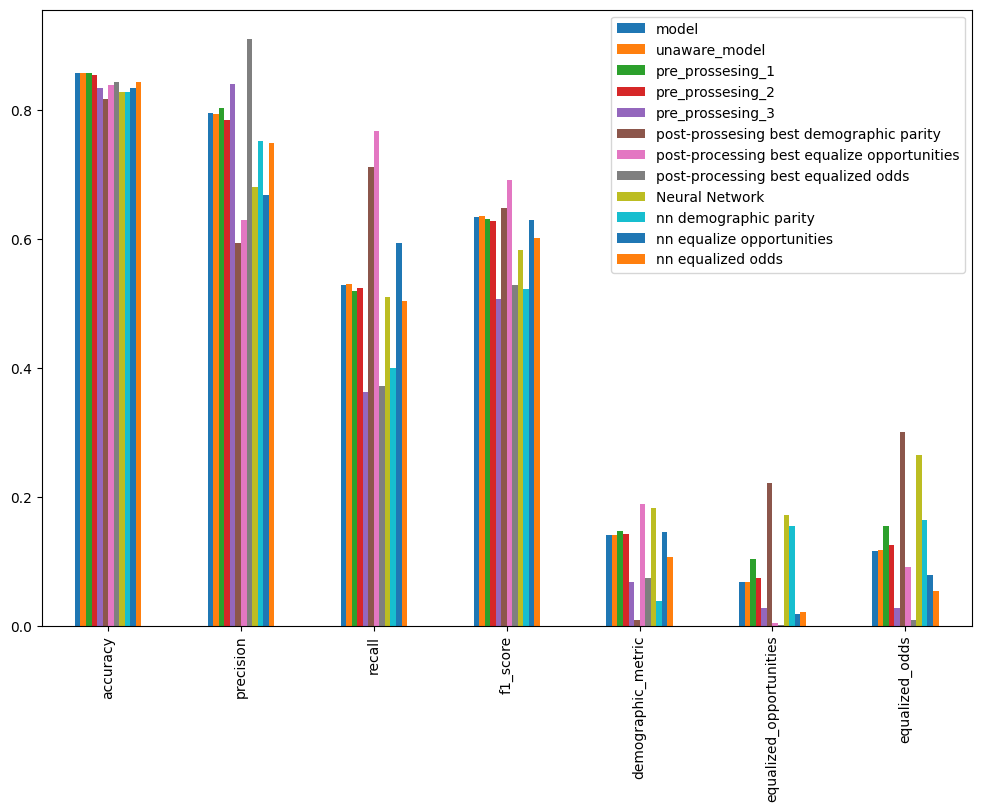

In [43]:
all_results = pd.concat([all_results, equalize_odds_metrics.T],axis=1)
all_results.plot(kind="bar",figsize=(12,8))

# usefull survey papers

https://arxiv.org/pdf/1908.09635.pdf  
https://arxiv.org/pdf/2111.03015.pdf   
https://arxiv.org/pdf/1802.06309.pdf 